In [28]:
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
import seaborn as sns
import random
from random import randint
from augment_functions import random_mask, resize_encoder
import torch.nn.functional as F
from torchmetrics.functional.image.ssim import structural_similarity_index_measure
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from downstream_model_lstm_no_decoder.downstream_task_main import downstream_task as downstream_task_lstm_no_decoder

In [29]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)


In [30]:
def resize_encoder(sample):
    sample = F.interpolate(sample, size=(144, 72), mode='bicubic', align_corners=False)
    return sample

def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image

class WeatherBenchDatasetWindow(Dataset):
    def __init__(self, data, context_length, target_length, stride=1, mask_prob_low=0.7, mask_prob_high=0.7):
        self.data = data
        self.context_length = context_length
        self.target_length = target_length
        self.stride = stride
        self.mask_prob_low=mask_prob_low
        self.mask_prob_high=mask_prob_high
        
    def __len__(self):
        return (self.data.shape[0] - (self.context_length + self.target_length)) // self.stride + 1

    def __getitem__(self, idx):
        x = random_mask(resize_encoder(self.data[idx:idx + self.context_length]), mask_prob_low=self.mask_prob_low, mask_prob_high=self.mask_prob_high)
        y = self.data[idx + self.context_length:idx + self.context_length + self.target_length]
        y_masked = random_mask(resize_encoder(y), mask_prob_low=self.mask_prob_low, mask_prob_high=self.mask_prob_high)
        return x, y_masked, y

In [31]:
seq2seq_model = torch.load('downstream_model_no_decoder_5.pth', weights_only=False, map_location=DEVICE)
model = torch.load('simclr_decoder_freeze.pth', weights_only=False, map_location=DEVICE)
model.eval()
seq2seq_model.eval()

OUTPUT_LEN=100

seq2seq_model.output_len = OUTPUT_LEN

encoder_model = model.model.encoder
decoder_model = model.decoder

data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train+n_valid:]


BATCH_SIZE = 128
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std


In [32]:
def prepare_inputs(input_data, output_data, encoder_model):
    B, T, C, H, W = input_data.shape
    input_data = input_data.reshape(B*T, C, H, W)
    input_encoded_data, _ = encoder_model(input_data)

    input_encoded_data = input_encoded_data.reshape(B, T, -1)
    B, T, C, H, W = output_data.shape
    output_data = output_data.reshape(B*T, C, H, W)

    output_encoded_data = encoder_model(output_data)[0]
    output_encoded_data = output_encoded_data.reshape(B, T, -1)
    return input_encoded_data, output_encoded_data

In [33]:
def compute_error(testloader, encoder_model, seq2seq_model, decoder_model, std, mean, train_data, teacher_forcing=False):
    mse_loss = torch.nn.MSELoss(reduction='none')
    mse = []
    ssim = []
    psnr = []
    for batch in testloader:
        with torch.no_grad():
            input_data = batch[0].to(DEVICE)
            output_data_masked = batch[1].to(DEVICE)
            output_data = batch[2].to(DEVICE)
            input_encoded_data, output_encoded_data = prepare_inputs(input_data, output_data_masked, encoder_model)
            if teacher_forcing:
                model_pred = seq2seq_model(input_encoded_data, output_encoded_data, eps=1.0)
            else:
                model_pred = seq2seq_model(input_encoded_data)
            if model_pred.ndim == 2:
                model_pred = model_pred.unsqueeze(0)
            B, T, L = model_pred.shape
            model_pred = model_pred.reshape(B*T, L)
            output_encoded_data = output_encoded_data.reshape(B*T, L)
            decoded_data = decoder_model(model_pred)
            B, T, C, H, W = output_data.shape
            decoded_data = decoded_data.reshape(B, T, C, H, W)

            mse_l = mse_loss(decoded_data, output_data)
            mse_l = mse_l.mean(dim=(0, 2, 3, 4)).cpu().numpy()

            decoded_data_ = decoded_data.reshape(B*T, C, H, W)
            output_data_ = output_data.reshape(B*T, C, H, W)
            decoded_data_ = decoded_data_ * std + mean
            output_data_ = output_data_ * std + mean

            x_min = train_data.amin(dim=(0, 2, 3), keepdim=True)
            x_max = train_data.amax(dim=(0, 2, 3), keepdim=True)

            decoded_data_ = (decoded_data_ - x_min) / (x_max - x_min + 1e-8)
            output_data_ = (output_data_ - x_min) / (x_max - x_min + 1e-8)

            ssim_l = structural_similarity_index_measure(decoded_data_, output_data_, data_range=1.0, reduction=None)
            psnr_l = peak_signal_noise_ratio(decoded_data_, output_data_, reduction=None, data_range=1.0, dim=[1,2,3])

            ssim_l = ssim_l.reshape(B, T).mean(0).cpu().numpy()
            psnr_l = psnr_l.reshape(B, T).mean(0).cpu().numpy()

            mse.append(mse_l)
            ssim.append(ssim_l)
            psnr.append(psnr_l)

    print(f"MSE Loss: {np.mean(mse, axis=0)}")
    print(f"Masked Normalised SSIM Loss: {np.mean(ssim, axis=0)}")
    print(f"Masked Normalised PSNR Loss: {np.mean(psnr, axis=0)}")
    mse_time = np.mean(mse, axis=0)
    ssim_time = np.mean(ssim, axis=0)
    psnr_time = np.mean(psnr, axis=0)
    mse_thresh = 1.2 * mse_time[0]
    ssim_thresh = 0.8 * ssim_time[0]
    psnr_thresh = 0.8 * psnr_time[0]
    timesteps = np.arange(len(mse_time))
    print(timesteps)

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    axes[0].plot(timesteps, mse_time, label='MSE', color='blue')
    axes[0].axhline(y=mse_thresh, color='red', linestyle='--', label='20% above starting value')
    axes[0].set_ylabel('MSE')
    axes[0].legend()
    axes[0].grid(True)


    axes[1].plot(timesteps, ssim_time, label='SSIM', color='green')
    axes[1].axhline(y=ssim_thresh, color='red', linestyle='--', label='20% below starting value')
    axes[1].set_ylabel('SSIM')
    axes[1].legend()
    axes[1].grid(True)


    axes[2].plot(timesteps, psnr_time, label='PSNR', color='orange')
    axes[2].axhline(y=psnr_thresh, color='red', linestyle='--', label='20% below starting value')
    axes[2].set_ylabel('PSNR')
    axes[2].set_xlabel('Time step')
    axes[2].legend()
    axes[2].grid(True)

    for ax in axes:
        ax.set_xticks(timesteps) 

    mse_cross = np.argmax(mse_time > mse_thresh)
    ssim_cross = np.argmax(ssim_time < ssim_thresh)
    psnr_cross = np.argmax(psnr_time < psnr_thresh)
    axes[0].axvline(x=mse_cross, color='purple', linestyle=':', label='Threshold crossed')
    axes[1].axvline(x=ssim_cross, color='purple', linestyle=':', label='Threshold crossed')
    axes[2].axvline(x=psnr_cross, color='purple', linestyle=':', label='Threshold crossed')

    plt.suptitle('Metrics Over Time with 20% Threshold Lines')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

In [34]:
test_dataset = WeatherBenchDatasetWindow(data=test_data, context_length=30, target_length=OUTPUT_LEN, stride=1, mask_prob_low=0.2, mask_prob_high=0.9)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

MSE Loss: [0.19173083 0.25865534 0.29625186 0.3158904  0.32726645 0.33371228
 0.33768484 0.34072018 0.34300846 0.3439219  0.34501678 0.3472341
 0.34928924 0.35091785 0.3528049  0.35488382 0.3562863  0.35810426
 0.3598468  0.36175802 0.36488748 0.36756608 0.37046483 0.37371707
 0.37693757 0.37954888 0.38229746 0.38491157 0.3878067  0.39125887
 0.394351   0.39748904 0.4002934  0.40368733 0.40683383 0.4107573
 0.4146927  0.41928172 0.42369217 0.4270749  0.4308711  0.434199
 0.438278   0.44387865 0.44891214 0.45279056 0.45733616 0.46231493
 0.46825525 0.47449118 0.48121348 0.48566204 0.49005032 0.4938507
 0.49693176 0.49962568 0.5035297  0.50601417 0.5075693  0.5084847
 0.51117325 0.51197565 0.5139147  0.5179707  0.52352256 0.52703303
 0.5297099  0.53168935 0.5350461  0.53802747 0.5414453  0.5454777
 0.5499047  0.55277354 0.5539876  0.5553773  0.5577108  0.5600873
 0.5620431  0.56394994 0.5630048  0.56359464 0.5659929  0.5696974
 0.5731136  0.5767878  0.5815168  0.5840538  0.58431834 0.584

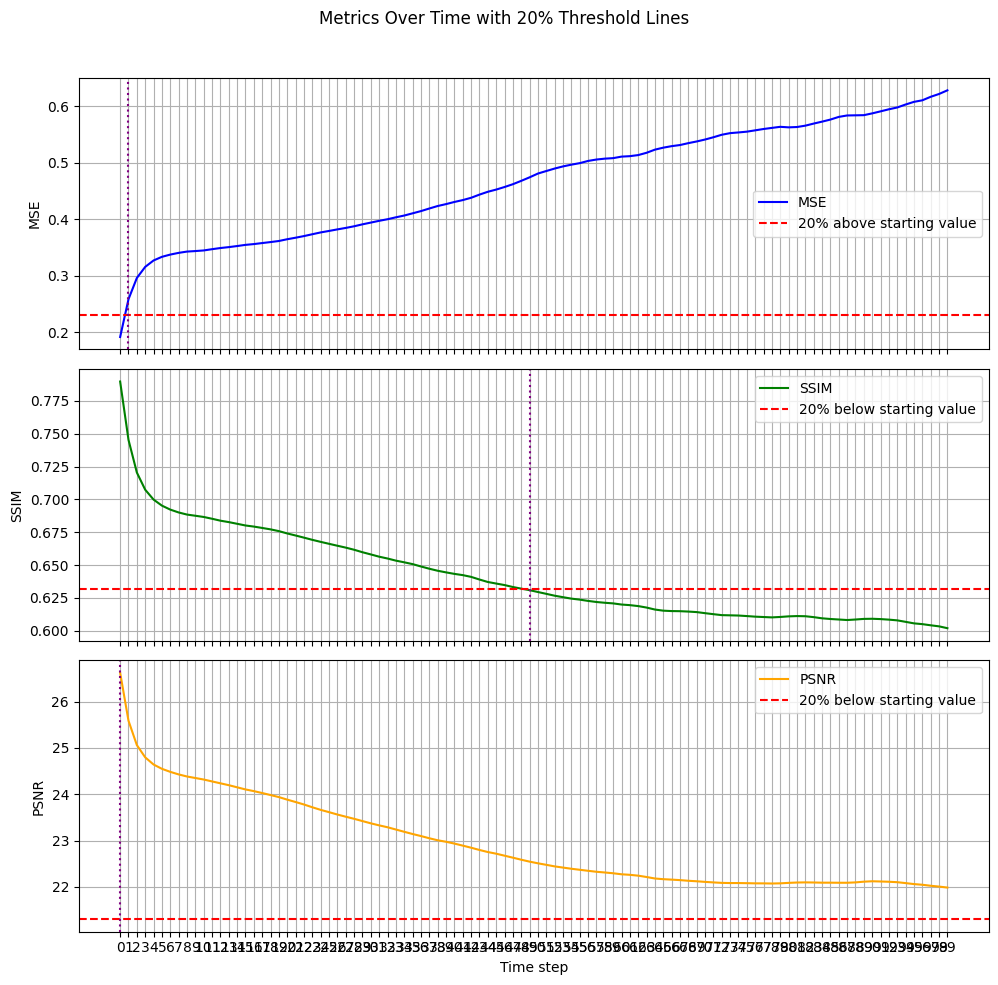

In [35]:
compute_error(testloader, encoder_model, seq2seq_model, decoder_model, std, mean, train_data, teacher_forcing=False)

In [36]:
#compute_error(testloader, encoder_model, seq2seq_model, decoder_model, std, mean, train_data, teacher_forcing=True)